In [1]:
%pip -q install albumentations opencv-python pandas numpy scikit-learn tqdm lxml

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import torch, torchvision
import sys, platform
print("Torch:", torch.__version__, "| TorchVision:", torchvision.__version__)
print("Python:", sys.version)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Device:", torch.cuda.get_device_name(0))

Torch: 2.8.0+cu126 | TorchVision: 0.23.0+cu126
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
CUDA Available: True
CUDA Device: NVIDIA A100-SXM4-80GB


In [26]:
# --- Step 2: Paths, Seeds, Config ---
import os, random, json
from pathlib import Path
import numpy as np
import torch

# Root paths
DATA_ROOT = Path("/content/data/raw/kaggle_roadsign")
IMAGES_DIR = DATA_ROOT / "images"
ANN_DIR = DATA_ROOT / "annotations"

WORK_DIR = Path("/content/data/processed/crops_stop_binary")
SPLIT_DIR = WORK_DIR / "splits"
CKPT_DIR = Path("checkpoints/smallcnn_plus")
LOG_DIR = Path("logs")

for p in [WORK_DIR, SPLIT_DIR, CKPT_DIR, LOG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Reproducibility
SEED = 123
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Training hyperparams (tweak as needed)
CFG = dict(
    input_size=224,
    pos_context=0.10,
    use_background_negs=False,
    neg_pos_ratio=1.0,
    batch_size=64,
    epochs=30,
    optimizer='adamw',
    lr=3e-4,
    weight_decay=1e-4,
    use_focal=False,
    pos_weight=None,
    dropout=0.30,
    num_workers=4,
    amp=True,
    patience=7,
    metric_for_best='pr_auc',
)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CFG


{'input_size': 224,
 'pos_context': 0.1,
 'use_background_negs': False,
 'neg_pos_ratio': 1.0,
 'batch_size': 64,
 'epochs': 30,
 'optimizer': 'adamw',
 'lr': 0.0003,
 'weight_decay': 0.0001,
 'use_focal': False,
 'pos_weight': None,
 'dropout': 0.3,
 'num_workers': 4,
 'amp': True,
 'patience': 7,
 'metric_for_best': 'pr_auc'}

In [27]:
# --- Step 3: Parse VOC XML annotations ---
from lxml import etree
from collections import defaultdict

CLASS_NAMES = ["speedlimit", "crosswalk", "trafficlight", "stop"]

def parse_voc_xml(xml_path):
    xml = etree.parse(str(xml_path)).getroot()
    filename = xml.findtext("filename")
    size = xml.find("size")
    W = int(size.findtext("width")); H = int(size.findtext("height"))

    objects = []
    for obj in xml.findall("object"):
        cls = obj.findtext("name").strip()
        bnd = obj.find("bndbox")
        xmin = int(float(bnd.findtext("xmin"))); ymin = int(float(bnd.findtext("ymin")))
        xmax = int(float(bnd.findtext("xmax"))); ymax = int(float(bnd.findtext("ymax")))
        # clamp
        xmin = max(0, min(xmin, W-1)); xmax = max(0, min(xmax, W-1))
        ymin = max(0, min(ymin, H-1)); ymax = max(0, min(ymax, H-1))
        if xmax <= xmin or ymax <= ymin:
            continue
        objects.append(dict(cls=cls, bbox=(xmin, ymin, xmax, ymax)))
    return dict(filename=filename, width=W, height=H, objects=objects)

# Build image-level records
records = []
for xml_file in sorted(ANN_DIR.glob("*.xml")):
    rec = parse_voc_xml(xml_file)
    img_path = IMAGES_DIR / rec["filename"]
    if not img_path.exists():
        # Some datasets store filename in xml as basename; ensure it matches
        # Try to find by stem if not found (optional)
        continue
    rec["image_path"] = str(img_path)
    rec["contains_stop"] = any(o["cls"] == "stop" for o in rec["objects"])
    records.append(rec)

print(f"Parsed {len(records)} images.")
print("Contains stop counts:", sum(r["contains_stop"] for r in records))
cls_counts = defaultdict(int)
for r in records:
    for o in r["objects"]:
        cls_counts[o["cls"]] += 1
print("Object counts:", dict(cls_counts) )


Parsed 877 images.
Contains stop counts: 91
Object counts: {'trafficlight': 170, 'speedlimit': 783, 'crosswalk': 200, 'stop': 91}


In [28]:
# --- Step 4: 5-Fold CV (image-level) ---
from sklearn.model_selection import StratifiedKFold
import pandas as pd

df = pd.DataFrame([{
    "image_path": r["image_path"],
    "contains_stop": int(r["contains_stop"])
} for r in records])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
folds = []
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(df["image_path"], df["contains_stop"])):
    tr = df.iloc[train_idx].reset_index(drop=True)
    va = df.iloc[val_idx].reset_index(drop=True)
    folds.append((tr, va))
    tr.to_csv(SPLIT_DIR / f"train_fold{fold_idx}.csv", index=False)
    va.to_csv(SPLIT_DIR / f"val_fold{fold_idx}.csv", index=False)

print("Saved 5 folds to", SPLIT_DIR)


Saved 5 folds to /content/data/processed/crops_stop_binary/splits


In [29]:
# --- Step 5: Crop rules and utilities ---
import cv2

def expand_box(bbox, W, H, margin=0.10):
    xmin, ymin, xmax, ymax = bbox
    w = xmax - xmin; h = ymax - ymin
    dx = int(w * margin); dy = int(h * margin)
    nxmin = max(0, xmin - dx); nymin = max(0, ymin - dy)
    nxmax = min(W-1, xmax + dx); nymax = min(H-1, ymax + dy)
    return (nxmin, nymin, nxmax, nymax)

def iou(a, b):
    ax1, ay1, ax2, ay2 = a; bx1, by1, bx2, by2 = b
    inter_x1, inter_y1 = max(ax1, bx1), max(ay1, by1)
    inter_x2, inter_y2 = min(ax2, bx2), min(ay2, by2)
    iw = max(0, inter_x2 - inter_x1); ih = max(0, inter_y2 - inter_y1)
    inter = iw * ih
    area_a = max(0, (ax2-ax1)) * max(0, (ay2-ay1))
    area_b = max(0, (bx2-bx1)) * max(0, (by2-by1))
    union = area_a + area_b - inter
    return inter / union if union > 0 else 0.0

def sample_background_windows(W, H, boxes, n_samples=2, size_range=(0.15, 0.35), max_tries=50):
    """Random background crops that avoid significant overlap with any GT box."""
    wins = []
    for _ in range(n_samples):
        ok = False
        for _ in range(max_tries):
            s = random.uniform(*size_range)
            w = int(W * s); h = int(H * s)
            if w < 16 or h < 16:
                continue
            x1 = random.randint(0, max(0, W - w))
            y1 = random.randint(0, max(0, H - h))
            x2, y2 = x1 + w, y1 + h
            cand = (x1, y1, min(W-1, x2), min(H-1, y2))
            if all(iou(cand, b) < 0.05 for b in boxes):
                wins.append(cand); ok = True; break
        if not ok:
            wins.append((W//4, H//4, 3*W//4, 3*H//4))
    return wins

def collect_crops_for_image(rec, pos_context=0.10, use_bg=False):
    """Return lists of positive and negative crop boxes for one image."""
    W, H = rec["width"], rec["height"]
    pos_boxes = []
    neg_boxes = []
    all_boxes = [o["bbox"] for o in rec["objects"]]

    for o in rec["objects"]:
        if o["cls"] == "stop":
            pos_boxes.append(expand_box(o["bbox"], W, H, margin=pos_context))
        else:
            neg_boxes.append(o["bbox"])

    if use_bg:
        neg_boxes.extend(sample_background_windows(W, H, all_boxes, n_samples=2))
    return pos_boxes, neg_boxes


In [30]:
# --- Step 6: Augmentations ---
import albumentations as A
import cv2

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def build_train_aug(size=224):
    return A.Compose([
        A.LongestMaxSize(max_size=size),
        A.PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
        A.Affine(
            scale=(0.9, 1.1),
            translate_percent=(0.0, 0.05),
            rotate=(-15, 15),
            p=0.7
        ),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.3),
        A.MotionBlur(blur_limit=3, p=0.1),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])

def build_val_aug(size=224):
    return A.Compose([
        A.LongestMaxSize(max_size=size),
        A.PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])




In [31]:
# --- Step 7: Dataset & DataLoader ---
from torch.utils.data import Dataset, DataLoader

class StopCropDataset(Dataset):
    """
    On-the-fly crop generator for a set of images.
    For each __getitem__, we (probabilistically) choose positive/negative crops
    to roughly respect neg_pos_ratio each epoch.
    """
    def __init__(self, df_split, records_by_path, transform, input_size=224,
                 neg_pos_ratio=1.0, pos_context=0.10, use_background_negs=False,
                 epoch_len_factor=4):
        """
        df_split: DataFrame with 'image_path' and 'contains_stop' (int).
        records_by_path: dict image_path -> parsed record
        epoch_len_factor: controls how many samples per image per epoch (rough)
        """
        self.df = df_split.reset_index(drop=True)
        self.records = records_by_path
        self.transform = transform
        self.input_size = input_size
        self.neg_pos_ratio = float(neg_pos_ratio)
        self.pos_context = pos_context
        self.use_background_negs = use_background_negs

        self.per_image = []
        total_pos, total_neg = 0, 0
        for _, row in self.df.iterrows():
            rec = records_by_path[row.image_path]
            pos_boxes, neg_boxes = collect_crops_for_image(rec, pos_context=self.pos_context, use_bg=self.use_background_negs)
            self.per_image.append((row.image_path, pos_boxes, neg_boxes))
            total_pos += len(pos_boxes); total_neg += len(neg_boxes)

        self.total_pos = total_pos
        self.total_neg = total_neg

        self.length = max(1, len(self.df) * epoch_len_factor)

    def __len__(self):
        return self.length

    def _load_img(self, path):
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(f"Cannot read image: {path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

    def __getitem__(self, idx):
        img_path, pos_boxes, neg_boxes = random.choice(self.per_image)
        choose_pos = True
        if len(pos_boxes) == 0 and len(neg_boxes) > 0:
            choose_pos = False
        elif len(pos_boxes) > 0 and len(neg_boxes) == 0:
            choose_pos = True
        else:
            choose_pos = (random.random() > (self.neg_pos_ratio / (1.0 + self.neg_pos_ratio)))

        img = self._load_img(img_path)
        H, W = img.shape[:2]

        if choose_pos and len(pos_boxes) > 0:
            bbox = random.choice(pos_boxes)
            label = 1.0
        else:
            if len(neg_boxes) == 0:
                bbox = random.choice(pos_boxes)
                label = 1.0
            else:
                bbox = random.choice(neg_boxes)
                label = 0.0

        x1, y1, x2, y2 = bbox
        crop = img[y1:y2, x1:x2]
        aug = self.transform(image=crop)
        img_t = aug["image"].transpose(2,0,1)

        return torch.from_numpy(img_t).float(), torch.tensor(label, dtype=torch.float32)

def make_loaders_for_fold(train_df, val_df, records_by_path, cfg):
    train_ds = StopCropDataset(
        train_df, records_by_path,
        transform=build_train_aug(cfg["input_size"]),
        input_size=cfg["input_size"],
        neg_pos_ratio=cfg["neg_pos_ratio"],
        pos_context=cfg["pos_context"],
        use_background_negs=cfg["use_background_negs"],
        epoch_len_factor=6
    )
    val_ds = StopCropDataset(
        val_df, records_by_path,
        transform=build_val_aug(cfg["input_size"]),
        input_size=cfg["input_size"],
        neg_pos_ratio=1.0,
        pos_context=cfg["pos_context"],
        use_background_negs=False,
        epoch_len_factor=2
    )
    train_loader = DataLoader(train_ds, batch_size=cfg["batch_size"], shuffle=True,
                              num_workers=cfg["num_workers"], pin_memory=True, drop_last=True, persistent_workers=True)
    val_loader   = DataLoader(val_ds, batch_size=cfg["batch_size"], shuffle=False,
                              num_workers=cfg["num_workers"], pin_memory=True, drop_last=False, persistent_workers=True)
    return train_loader, val_loader, train_ds, val_ds

records_by_path = {r["image_path"]: r for r in records}


In [32]:
# --- Step 8: SmallCNN+ ---
import torch.nn as nn
import torch.nn.functional as F

def conv_bn_relu(cin, cout, k=3, s=1, p=1):
    return nn.Sequential(
        nn.Conv2d(cin, cout, kernel_size=k, stride=s, padding=p, bias=False),
        nn.BatchNorm2d(cout),
        nn.ReLU(inplace=True)
    )

class ResidualBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.conv1 = nn.Conv2d(c, c, 3, 1, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(c)
        self.conv2 = nn.Conv2d(c, c, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(c)
    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))
        out = F.relu(out + identity, inplace=True)
        return out


import torch.nn as nn
import torch.nn.functional as F
import torch

def conv_bn_relu(cin, cout, k=3, s=1, p=1):
    return nn.Sequential(
        nn.Conv2d(cin, cout, kernel_size=k, stride=s, padding=p, bias=False),
        nn.BatchNorm2d(cout),
        nn.ReLU(inplace=True)
    )

class ResidualBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.conv1 = nn.Conv2d(c, c, 3, 1, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(c)
        self.conv2 = nn.Conv2d(c, c, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(c)
    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))
        out = F.relu(out + identity, inplace=True)
        return out

class SmallCNNPlus(nn.Module):
    def __init__(self, dropout=0.30, in_ch=3, widths=(32,64,128)):
        super().__init__()
        c1, c2, c3 = widths
        self.stem = conv_bn_relu(in_ch, c1, 3, 1, 1)
        self.resA1 = ResidualBlock(c1); self.resA2 = ResidualBlock(c1); self.poolA = nn.MaxPool2d(2)
        self.convAtoB = conv_bn_relu(c1, c2, 3, 1, 1)
        self.resB1 = ResidualBlock(c2); self.resB2 = ResidualBlock(c2); self.poolB = nn.MaxPool2d(2)
        self.convBtoC = conv_bn_relu(c2, c3, 3, 1, 1)
        self.resC1 = ResidualBlock(c3); self.resC2 = ResidualBlock(c3); self.poolC = nn.MaxPool2d(2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(c3, 1)
    def forward(self, x):
        x = self.stem(x)
        x = self.resA1(x); x = self.resA2(x); x = self.poolA(x)
        x = self.convAtoB(x)
        x = self.resB1(x); x = self.resB2(x); x = self.poolB(x)
        x = self.convBtoC(x)
        x = self.resC1(x); x = self.resC2(x); x = self.poolC(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        logits = self.fc(x).squeeze(-1)
        return logits


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = SmallCNNPlus(dropout=CFG["dropout"])
print(model)
print("Trainable params:", count_params(model))


SmallCNNPlus(
  (stem): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (resA1): ResidualBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (resA2): ResidualBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True,

In [33]:
# --- Step 9: Losses & Metrics ---
import math
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, logits, targets):
        bce = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        pt = probs*targets + (1-probs)*(1-targets)
        w = self.alpha*(1-pt).pow(self.gamma)
        loss = w * bce
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

def make_loss(cfg, pos_weight=None):
    if cfg["use_focal"]:
        return FocalLoss()
    else:
        if pos_weight is not None:
            pw = torch.tensor([pos_weight], dtype=torch.float32, device=DEVICE)
            return nn.BCEWithLogitsLoss(pos_weight=pw)
        else:
            return nn.BCEWithLogitsLoss()

@torch.no_grad()
def compute_metrics(logits, targets):
    probs = torch.sigmoid(logits).cpu().numpy()
    y = targets.cpu().numpy()
    try:
        roc = roc_auc_score(y, probs)
    except Exception:
        roc = float('nan')
    try:
        pr_auc = average_precision_score(y, probs)
    except Exception:
        pr_auc = float('nan')
    preds = (probs >= 0.5).astype(np.uint8)
    try:
        f1 = f1_score(y, preds)
    except Exception:
        f1 = float('nan')
    return dict(roc_auc=roc, pr_auc=pr_auc, f1=f1)


In [34]:
# --- Step 10: Optimizer, Scheduler, AMP helpers ---
from torch.optim import AdamW, SGD

def make_optimizer(params, cfg):
    if cfg["optimizer"].lower() == "adamw":
        opt = AdamW(params, lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    else:
        opt = SGD(params, lr=cfg["lr"], weight_decay=cfg["weight_decay"], momentum=0.9, nesterov=True)
    return opt

def make_scheduler(optimizer, total_epochs):
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs)
    return scheduler


In [35]:
# --- Step 11: Train/Val loops with early stopping & checkpointing ---
from copy import deepcopy
from time import time
from tqdm import tqdm

def run_one_epoch(model, loader, criterion, optimizer=None, amp=True):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    all_logits, all_targets = [], []
    running_loss = 0.0
    scaler = torch.amp.GradScaler('cuda', enabled=amp)

    for images, targets in tqdm(loader, disable=False):
        images = images.to(DEVICE, non_blocking=True)
        targets = targets.to(DEVICE, non_blocking=True)

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=amp):
                logits = model(images)
                loss = criterion(logits, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.amp.autocast('cuda', enabled=amp):
                logits = model(images)
                loss = criterion(logits, targets)

        running_loss += loss.item() * images.size(0)
        all_logits.append(logits.detach().cpu())
        all_targets.append(targets.detach().cpu())

    avg_loss = running_loss / len(loader.dataset)
    logits_cat = torch.cat(all_logits, dim=0)
    targets_cat = torch.cat(all_targets, dim=0)
    mets = compute_metrics(logits_cat, targets_cat)
    mets["loss"] = avg_loss
    return mets, logits_cat, targets_cat


def train_fold(fold_idx, train_df, val_df, cfg, save_dir):
    save_dir = Path(save_dir); save_dir.mkdir(parents=True, exist_ok=True)
    model = SmallCNNPlus(dropout=cfg["dropout"]).to(DEVICE)

    # Optional: estimate pos_weight roughly from available crops in one epoch of the training dataset
    _, _, train_ds, val_ds = make_loaders_for_fold(train_df, val_df, records_by_path, cfg)
    if cfg["pos_weight"] is None:
        pos = max(1, train_ds.total_pos)
        neg = max(1, train_ds.total_neg)
        est_pos_weight = neg / pos if pos > 0 else 1.0
    else:
        est_pos_weight = cfg["pos_weight"]

    criterion = make_loss(cfg, pos_weight=None if cfg["use_focal"] else est_pos_weight)
    optimizer = make_optimizer(model.parameters(), cfg)
    scheduler = make_scheduler(optimizer, cfg["epochs"])

    train_loader, val_loader, train_ds, val_ds = make_loaders_for_fold(train_df, val_df, records_by_path, cfg)

    best_metric = -float('inf')
    best_state = None
    history = []

    patience = cfg["patience"]; bad_epochs = 0

    for epoch in range(1, cfg["epochs"]+1):
        print(f"\n[Fold {fold_idx}] Epoch {epoch}/{cfg['epochs']}")
        tr_mets, _, _ = run_one_epoch(model, train_loader, criterion, optimizer=optimizer, amp=cfg["amp"])
        vl_mets, _, _ = run_one_epoch(model, val_loader, criterion, optimizer=None, amp=cfg["amp"])
        scheduler.step()

        row = {"epoch": epoch, "train": tr_mets, "val": vl_mets, "lr": optimizer.param_groups[0]["lr"]}
        history.append(row)
        print(f"train loss {tr_mets['loss']:.4f} | val loss {vl_mets['loss']:.4f} | "
              f"val ROC {vl_mets['roc_auc']:.4f} | val PR {vl_mets['pr_auc']:.4f} | val F1 {vl_mets['f1']:.4f}")

        key = cfg["metric_for_best"]
        score = vl_mets.get(key, -float('inf'))
        if math.isnan(score):
            score = -float('inf')

        if score > best_metric:
            best_metric = score
            best_state = deepcopy(model.state_dict())
            torch.save(best_state, save_dir / f"best_fold{fold_idx}.pt")
            torch.save(model.state_dict(), save_dir / f"last_fold{fold_idx}.pt")
            with open(save_dir / f"history_fold{fold_idx}.json", "w") as f:
                json.dump(history, f, indent=2)
            bad_epochs = 0
        else:
            bad_epochs += 1
            torch.save(model.state_dict(), save_dir / f"last_fold{fold_idx}.pt")
            with open(save_dir / f"history_fold{fold_idx}.json", "w") as f:
                json.dump(history, f, indent=2)
            if bad_epochs >= patience:
                print(f"Early stopping at epoch {epoch}. Best {key}={best_metric:.4f}.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history


In [36]:
# --- Step 13: Cross-validated training & evaluation ---
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_loader(model, loader, cfg, title="Eval"):
    criterion = make_loss(cfg, pos_weight=None if cfg["use_focal"] else 1.0)
    mets, logits_cat, targets_cat = run_one_epoch(model, loader, criterion, optimizer=None, amp=cfg["amp"])
    probs = torch.sigmoid(logits_cat).numpy()
    y_true = targets_cat.numpy().astype(int)
    y_pred = (probs >= 0.5).astype(int)
    print(f"{title} metrics:", {k: round(v, 4) for k, v in mets.items()})
    print("\nClassification report (threshold=0.5):")
    print(classification_report(y_true, y_pred, digits=4, target_names=["non-stop", "stop"]))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    return mets

# Train & evaluate across 5 folds
all_fold_metrics = []
for fold_idx, (train_df, val_df) in enumerate(folds):
    model, history = train_fold(fold_idx, train_df, val_df, CFG, CKPT_DIR)
    # Rebuild val loader to evaluate with best model loaded
    _, val_loader, _, _ = make_loaders_for_fold(train_df, val_df, records_by_path, CFG)
    print(f"\n=== Fold {fold_idx}: Validation Evaluation ===")
    mets = evaluate_loader(model, val_loader, CFG, title=f"Fold {fold_idx} Val")
    all_fold_metrics.append(mets)

# Aggregate results across folds
def avg_metric(metric_name):
    xs = [m.get(metric_name, float('nan')) for m in all_fold_metrics]
    xs = [x for x in xs if not math.isnan(x)]
    return float(np.mean(xs)) if xs else float('nan')

summary = {
    "roc_auc_mean": avg_metric("roc_auc"),
    "pr_auc_mean":  avg_metric("pr_auc"),
    "f1_mean":      avg_metric("f1"),
    "loss_mean":    avg_metric("loss"),
}
print("\n=== 5-Fold Summary (Val) ===")
print(json.dumps(summary, indent=2))




[Fold 0] Epoch 1/30


100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


train loss 0.7048 | val loss 0.5218 | val ROC 0.9925 | val PR 0.9572 | val F1 0.5170

[Fold 0] Epoch 2/30


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


train loss 0.4812 | val loss 0.3272 | val ROC 0.9822 | val PR 0.8493 | val F1 0.7123

[Fold 0] Epoch 3/30


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


train loss 0.3059 | val loss 0.4071 | val ROC 0.9982 | val PR 0.9608 | val F1 0.5773

[Fold 0] Epoch 4/30


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


train loss 0.2865 | val loss 0.1572 | val ROC 0.9989 | val PR 0.9884 | val F1 0.8772

[Fold 0] Epoch 5/30


100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


train loss 0.2400 | val loss 0.2494 | val ROC 0.9990 | val PR 0.9881 | val F1 0.9500

[Fold 0] Epoch 6/30


100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


train loss 0.1598 | val loss 0.1228 | val ROC 0.9989 | val PR 0.9901 | val F1 0.9091

[Fold 0] Epoch 7/30


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


train loss 0.1547 | val loss 0.0509 | val ROC 0.9996 | val PR 0.9965 | val F1 0.9296

[Fold 0] Epoch 8/30


100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


train loss 0.1555 | val loss 0.0911 | val ROC 0.9999 | val PR 0.9990 | val F1 0.9394

[Fold 0] Epoch 9/30


100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


train loss 0.1630 | val loss 0.1295 | val ROC 1.0000 | val PR 1.0000 | val F1 0.7561

[Fold 0] Epoch 10/30


100%|██████████| 6/6 [00:01<00:00,  4.92it/s]


train loss 0.0920 | val loss 0.3043 | val ROC 1.0000 | val PR 1.0000 | val F1 0.5273

[Fold 0] Epoch 11/30


100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


train loss 0.1404 | val loss 0.1276 | val ROC 0.9988 | val PR 0.9867 | val F1 0.9524

[Fold 0] Epoch 12/30


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


train loss 0.1319 | val loss 0.0313 | val ROC 1.0000 | val PR 1.0000 | val F1 0.9355

[Fold 0] Epoch 13/30


100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


train loss 0.1367 | val loss 0.0315 | val ROC 1.0000 | val PR 1.0000 | val F1 0.9259

[Fold 0] Epoch 14/30


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


train loss 0.0863 | val loss 0.0263 | val ROC 1.0000 | val PR 1.0000 | val F1 0.9474

[Fold 0] Epoch 15/30


100%|██████████| 6/6 [00:01<00:00,  5.27it/s]


train loss 0.0927 | val loss 0.0233 | val ROC 1.0000 | val PR 1.0000 | val F1 1.0000

[Fold 0] Epoch 16/30


100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


train loss 0.0617 | val loss 0.0119 | val ROC 1.0000 | val PR 1.0000 | val F1 0.9831
Early stopping at epoch 16. Best pr_auc=1.0000.

=== Fold 0: Validation Evaluation ===


100%|██████████| 6/6 [00:01<00:00,  4.80it/s]


Fold 0 Val metrics: {'roc_auc': np.float64(0.9984), 'pr_auc': np.float64(0.975), 'f1': 0.8478, 'loss': 0.1532}

Classification report (threshold=0.5):
              precision    recall  f1-score   support

    non-stop     1.0000    0.9553    0.9771       313
        stop     0.7358    1.0000    0.8478        39

    accuracy                         0.9602       352
   macro avg     0.8679    0.9776    0.9125       352
weighted avg     0.9707    0.9602    0.9628       352

Confusion matrix:
 [[299  14]
 [  0  39]]

[Fold 1] Epoch 1/30


100%|██████████| 6/6 [00:01<00:00,  4.38it/s]


train loss 0.6959 | val loss 0.5040 | val ROC 0.9488 | val PR 0.6942 | val F1 0.4783

[Fold 1] Epoch 2/30


100%|██████████| 6/6 [00:01<00:00,  4.59it/s]


train loss 0.4735 | val loss 0.8169 | val ROC 0.9192 | val PR 0.8164 | val F1 0.5827

[Fold 1] Epoch 3/30


100%|██████████| 6/6 [00:01<00:00,  4.77it/s]


train loss 0.3140 | val loss 0.3553 | val ROC 0.9928 | val PR 0.9663 | val F1 0.5412

[Fold 1] Epoch 4/30


100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


train loss 0.2726 | val loss 0.2918 | val ROC 0.9958 | val PR 0.9588 | val F1 0.7000

[Fold 1] Epoch 5/30


100%|██████████| 6/6 [00:01<00:00,  4.49it/s]


train loss 0.1714 | val loss 0.3556 | val ROC 0.9989 | val PR 0.9922 | val F1 0.9600

[Fold 1] Epoch 6/30


100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


train loss 0.1428 | val loss 0.0664 | val ROC 1.0000 | val PR 1.0000 | val F1 0.9846

[Fold 1] Epoch 7/30


100%|██████████| 6/6 [00:01<00:00,  4.72it/s]


train loss 0.1838 | val loss 0.1895 | val ROC 0.9974 | val PR 0.9748 | val F1 0.7273

[Fold 1] Epoch 8/30


100%|██████████| 6/6 [00:01<00:00,  4.69it/s]


train loss 0.1659 | val loss 0.1660 | val ROC 1.0000 | val PR 1.0000 | val F1 0.7568

[Fold 1] Epoch 9/30


100%|██████████| 6/6 [00:01<00:00,  4.76it/s]


train loss 0.1163 | val loss 0.0834 | val ROC 1.0000 | val PR 1.0000 | val F1 0.9697

[Fold 1] Epoch 10/30


100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


train loss 0.0900 | val loss 0.0543 | val ROC 1.0000 | val PR 1.0000 | val F1 0.9655

[Fold 1] Epoch 11/30


100%|██████████| 6/6 [00:01<00:00,  4.46it/s]


train loss 0.0815 | val loss 0.0406 | val ROC 1.0000 | val PR 1.0000 | val F1 1.0000

[Fold 1] Epoch 12/30


100%|██████████| 6/6 [00:01<00:00,  4.92it/s]


train loss 0.1496 | val loss 0.0969 | val ROC 0.9992 | val PR 0.9930 | val F1 0.8923

[Fold 1] Epoch 13/30


100%|██████████| 6/6 [00:01<00:00,  4.43it/s]


train loss 0.0981 | val loss 0.2513 | val ROC 0.9998 | val PR 0.9987 | val F1 0.9870
Early stopping at epoch 13. Best pr_auc=1.0000.

=== Fold 1: Validation Evaluation ===


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


Fold 1 Val metrics: {'roc_auc': np.float64(1.0), 'pr_auc': np.float64(1.0), 'f1': 1.0, 'loss': 0.0188}

Classification report (threshold=0.5):
              precision    recall  f1-score   support

    non-stop     1.0000    1.0000    1.0000       323
        stop     1.0000    1.0000    1.0000        29

    accuracy                         1.0000       352
   macro avg     1.0000    1.0000    1.0000       352
weighted avg     1.0000    1.0000    1.0000       352

Confusion matrix:
 [[323   0]
 [  0  29]]

[Fold 2] Epoch 1/30


100%|██████████| 6/6 [00:01<00:00,  5.07it/s]


train loss 0.7497 | val loss 0.3988 | val ROC 0.9801 | val PR 0.8867 | val F1 0.7077

[Fold 2] Epoch 2/30


100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


train loss 0.4939 | val loss 1.5206 | val ROC 0.9636 | val PR 0.7552 | val F1 0.3627

[Fold 2] Epoch 3/30


100%|██████████| 6/6 [00:01<00:00,  5.53it/s]


train loss 0.3985 | val loss 0.1012 | val ROC 0.9999 | val PR 0.9980 | val F1 0.9167

[Fold 2] Epoch 4/30


100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


train loss 0.2925 | val loss 0.1184 | val ROC 1.0000 | val PR 1.0000 | val F1 0.9643

[Fold 2] Epoch 5/30


100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


train loss 0.2027 | val loss 0.2423 | val ROC 0.9968 | val PR 0.9764 | val F1 0.6429

[Fold 2] Epoch 6/30


100%|██████████| 6/6 [00:01<00:00,  5.66it/s]


train loss 0.1658 | val loss 0.1205 | val ROC 1.0000 | val PR 1.0000 | val F1 1.0000

[Fold 2] Epoch 7/30


100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


train loss 0.1781 | val loss 0.4486 | val ROC 1.0000 | val PR 1.0000 | val F1 1.0000

[Fold 2] Epoch 8/30


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


train loss 0.1335 | val loss 0.0373 | val ROC 1.0000 | val PR 1.0000 | val F1 1.0000

[Fold 2] Epoch 9/30


100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


train loss 0.1093 | val loss 0.0815 | val ROC 1.0000 | val PR 1.0000 | val F1 0.8533

[Fold 2] Epoch 10/30


100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


train loss 0.1307 | val loss 0.1166 | val ROC 1.0000 | val PR 1.0000 | val F1 1.0000

[Fold 2] Epoch 11/30


100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


train loss 0.1783 | val loss 0.1180 | val ROC 1.0000 | val PR 1.0000 | val F1 1.0000
Early stopping at epoch 11. Best pr_auc=1.0000.

=== Fold 2: Validation Evaluation ===


100%|██████████| 6/6 [00:01<00:00,  4.71it/s]


Fold 2 Val metrics: {'roc_auc': np.float64(1.0), 'pr_auc': np.float64(1.0), 'f1': 0.9167, 'loss': 0.092}

Classification report (threshold=0.5):
              precision    recall  f1-score   support

    non-stop     1.0000    0.9739    0.9868       306
        stop     0.8462    1.0000    0.9167        44

    accuracy                         0.9771       350
   macro avg     0.9231    0.9869    0.9517       350
weighted avg     0.9807    0.9771    0.9779       350

Confusion matrix:
 [[298   8]
 [  0  44]]

[Fold 3] Epoch 1/30


100%|██████████| 6/6 [00:01<00:00,  4.53it/s]


train loss 0.6758 | val loss 1.9623 | val ROC 0.8995 | val PR 0.4905 | val F1 0.3200

[Fold 3] Epoch 2/30


100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


train loss 0.2872 | val loss 0.3036 | val ROC 0.9965 | val PR 0.9450 | val F1 0.6047

[Fold 3] Epoch 3/30


100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


train loss 0.2686 | val loss 0.1789 | val ROC 0.9989 | val PR 0.9883 | val F1 0.9492

[Fold 3] Epoch 4/30


100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


train loss 0.2201 | val loss 0.0928 | val ROC 1.0000 | val PR 1.0000 | val F1 0.8718

[Fold 3] Epoch 5/30


100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


train loss 0.1580 | val loss 0.0827 | val ROC 0.9996 | val PR 0.9962 | val F1 0.9722

[Fold 3] Epoch 6/30


100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


train loss 0.2117 | val loss 0.3364 | val ROC 0.9940 | val PR 0.8863 | val F1 0.5926

[Fold 3] Epoch 7/30


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


train loss 0.1174 | val loss 0.1414 | val ROC 0.9997 | val PR 0.9979 | val F1 0.9737

[Fold 3] Epoch 8/30


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


train loss 0.0860 | val loss 0.0823 | val ROC 0.9992 | val PR 0.9906 | val F1 0.9231

[Fold 3] Epoch 9/30


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


train loss 0.0860 | val loss 0.1217 | val ROC 0.9996 | val PR 0.9954 | val F1 0.9167

[Fold 3] Epoch 10/30


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


train loss 0.0875 | val loss 0.0612 | val ROC 0.9998 | val PR 0.9970 | val F1 0.9615

[Fold 3] Epoch 11/30


100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


train loss 0.0913 | val loss 0.0643 | val ROC 0.9998 | val PR 0.9983 | val F1 0.9195
Early stopping at epoch 11. Best pr_auc=1.0000.

=== Fold 3: Validation Evaluation ===


100%|██████████| 6/6 [00:01<00:00,  4.56it/s]


Fold 3 Val metrics: {'roc_auc': np.float64(0.9972), 'pr_auc': np.float64(0.9822), 'f1': 0.9213, 'loss': 0.0909}

Classification report (threshold=0.5):
              precision    recall  f1-score   support

    non-stop     1.0000    0.9773    0.9885       309
        stop     0.8542    1.0000    0.9213        41

    accuracy                         0.9800       350
   macro avg     0.9271    0.9887    0.9549       350
weighted avg     0.9829    0.9800    0.9807       350

Confusion matrix:
 [[302   7]
 [  0  41]]

[Fold 4] Epoch 1/30


100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


train loss 0.7642 | val loss 0.6776 | val ROC 0.9364 | val PR 0.8596 | val F1 0.4915

[Fold 4] Epoch 2/30


100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


train loss 0.4304 | val loss 0.1489 | val ROC 0.9983 | val PR 0.9841 | val F1 0.9118

[Fold 4] Epoch 3/30


100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


train loss 0.2620 | val loss 0.4746 | val ROC 0.9896 | val PR 0.8623 | val F1 0.5487

[Fold 4] Epoch 4/30


100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


train loss 0.2569 | val loss 1.3581 | val ROC 0.9447 | val PR 0.6637 | val F1 0.3684

[Fold 4] Epoch 5/30


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


train loss 0.1522 | val loss 0.1784 | val ROC 0.9910 | val PR 0.9753 | val F1 0.9667

[Fold 4] Epoch 6/30


100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


train loss 0.1382 | val loss 6.0563 | val ROC 0.4659 | val PR 0.2567 | val F1 0.0000

[Fold 4] Epoch 7/30


100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


train loss 0.1362 | val loss 0.2096 | val ROC 0.9995 | val PR 0.9967 | val F1 0.7593

[Fold 4] Epoch 8/30


100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


train loss 0.1361 | val loss 0.2016 | val ROC 0.9987 | val PR 0.9925 | val F1 0.7573

[Fold 4] Epoch 9/30


100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


train loss 0.1214 | val loss 0.1418 | val ROC 0.9972 | val PR 0.9769 | val F1 0.8696

[Fold 4] Epoch 10/30


100%|██████████| 6/6 [00:01<00:00,  5.03it/s]


train loss 0.1069 | val loss 0.0189 | val ROC 1.0000 | val PR 1.0000 | val F1 1.0000

[Fold 4] Epoch 11/30


100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


train loss 0.1049 | val loss 0.0874 | val ROC 1.0000 | val PR 1.0000 | val F1 0.8444

[Fold 4] Epoch 12/30


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


train loss 0.1064 | val loss 0.0793 | val ROC 0.9995 | val PR 0.9949 | val F1 0.9643

[Fold 4] Epoch 13/30


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


train loss 0.0848 | val loss 0.1593 | val ROC 0.9974 | val PR 0.9789 | val F1 0.9767

[Fold 4] Epoch 14/30


100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


train loss 0.0863 | val loss 0.0397 | val ROC 1.0000 | val PR 1.0000 | val F1 1.0000

[Fold 4] Epoch 15/30


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


train loss 0.0701 | val loss 0.1129 | val ROC 0.9995 | val PR 0.9958 | val F1 0.9577

[Fold 4] Epoch 16/30


100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


train loss 0.0685 | val loss 0.3341 | val ROC 0.9921 | val PR 0.9627 | val F1 0.9333

[Fold 4] Epoch 17/30


100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


train loss 0.0475 | val loss 0.0374 | val ROC 0.9999 | val PR 0.9988 | val F1 0.9825
Early stopping at epoch 17. Best pr_auc=1.0000.

=== Fold 4: Validation Evaluation ===


100%|██████████| 6/6 [00:01<00:00,  4.62it/s]

Fold 4 Val metrics: {'roc_auc': np.float64(0.9995), 'pr_auc': np.float64(0.9957), 'f1': 0.9714, 'loss': 0.0276}

Classification report (threshold=0.5):
              precision    recall  f1-score   support

    non-stop     0.9937    1.0000    0.9968       314
        stop     1.0000    0.9444    0.9714        36

    accuracy                         0.9943       350
   macro avg     0.9968    0.9722    0.9841       350
weighted avg     0.9943    0.9943    0.9942       350

Confusion matrix:
 [[314   0]
 [  2  34]]

=== 5-Fold Summary (Val) ===
{
  "roc_auc_mean": 0.9990218242724396,
  "pr_auc_mean": 0.9905883885761935,
  "f1_mean": 0.9314539279317003,
  "loss_mean": 0.07649658808479834
}


In [37]:
# Pick which fold to visualize
fold_idx = 0

import torch, pandas as pd
from pathlib import Path

# Load model
ckpt_path = CKPT_DIR / f"best_fold{fold_idx}.pt"
model = SmallCNNPlus(dropout=CFG["dropout"]).to(DEVICE)
model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
model.eval()

# Load that fold's val split
val_df = pd.read_csv(SPLIT_DIR / f"val_fold{fold_idx}.csv")
print(f"Fold {fold_idx} - val images:", len(val_df))


Fold 0 - val images: 176


In [38]:
import cv2, numpy as np
import albumentations as A
import matplotlib.pyplot as plt

val_tf = build_val_aug(CFG["input_size"])

def to_tensor(img_rgb):
    # apply same val transforms then convert to CHW float tensor
    aug = val_tf(image=img_rgb)
    x = aug["image"].transpose(2,0,1)  # HWC->CHW
    return torch.from_numpy(x).float()

@torch.no_grad()
def predict_crops_for_image(model, rec, max_pos=4, max_neg=4):
    """Returns a dict with original image, lists of (crop_bgr, prob, label, bbox)."""
    img = cv2.cvtColor(cv2.imread(rec["image_path"], cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    H, W = img.shape[:2]
    pos_boxes, neg_boxes = collect_crops_for_image(rec, pos_context=CFG["pos_context"], use_bg=False)

    # sample a few
    if len(pos_boxes) > max_pos:
        pos_boxes = random.sample(pos_boxes, max_pos)
    if len(neg_boxes) > max_neg:
        neg_boxes = random.sample(neg_boxes, max_neg)

    all_boxes = [(b, 1) for b in pos_boxes] + [(b, 0) for b in neg_boxes]
    if not all_boxes:
        return dict(img=img, crops=[])

    # batch inference
    batch = []
    vis = []
    for (x1,y1,x2,y2), y in all_boxes:
        crop = img[y1:y2, x1:x2]
        vis.append((crop.copy(), y, (x1,y1,x2,y2)))
        batch.append(to_tensor(crop))

    batch_t = torch.stack(batch, dim=0).to(DEVICE, non_blocking=True)
    with torch.amp.autocast('cuda', enabled=CFG["amp"] and DEVICE.type=='cuda'):
        logits = model(batch_t)
        probs = torch.sigmoid(logits).detach().cpu().numpy()

    # pack results
    out = []
    for (crop, y, box), p in zip(vis, probs):
        out.append(dict(crop_rgb=crop, prob=float(p), label=int(y), bbox=box))
    return dict(img=img, crops=out)



Image: /content/data/raw/kaggle_roadsign/images/road270.png


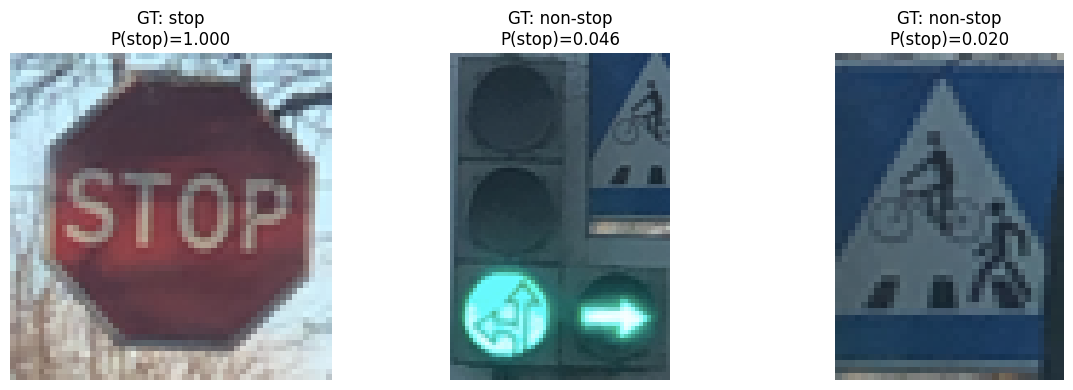


Image: /content/data/raw/kaggle_roadsign/images/road58.png


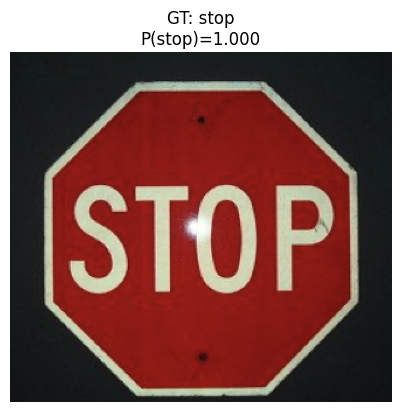


Image: /content/data/raw/kaggle_roadsign/images/road289.png


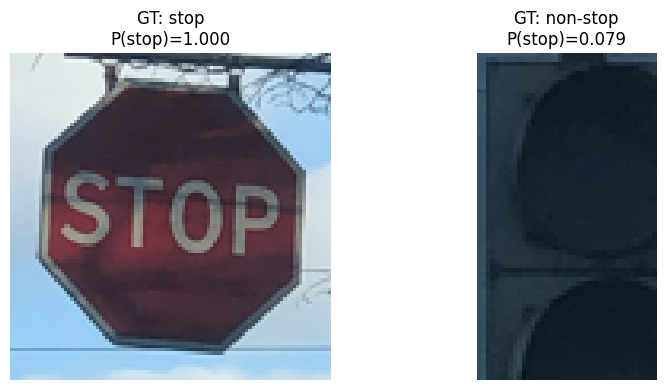

In [39]:
def show_crop_predictions(results, cols=4):
    crops = results["crops"]
    if not crops:
        print("No crops to display.")
        return
    rows = int(np.ceil(len(crops)/cols))
    plt.figure(figsize=(4*cols, 4*rows))
    for i, item in enumerate(crops):
        plt.subplot(rows, cols, i+1)
        plt.imshow(item["crop_rgb"])
        gt = "stop" if item["label"]==1 else "non-stop"
        plt.title(f"GT: {gt}\nP(stop)={item['prob']:.3f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Pick a few val images that contain a stop sign to make it interesting
val_paths = val_df["image_path"].tolist()
val_with_stop = [p for p in val_paths if records_by_path[p]["contains_stop"]]
sample_paths = random.sample(val_with_stop, k=min(3, len(val_with_stop))) if val_with_stop else random.sample(val_paths, k=min(3, len(val_paths)))

for p in sample_paths:
    rec = records_by_path[p]
    res = predict_crops_for_image(model, rec, max_pos=4, max_neg=4)
    print(f"\nImage: {p}")
    show_crop_predictions(res, cols=4)


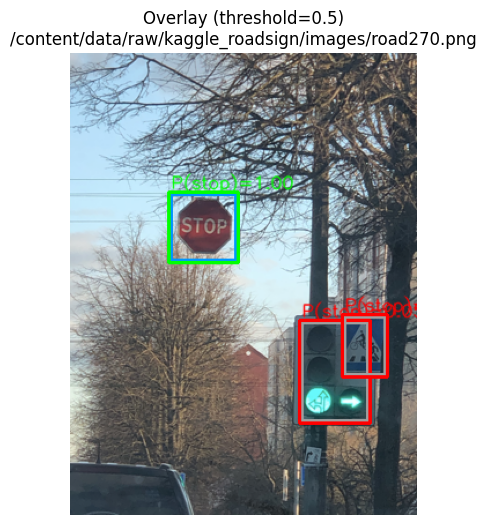

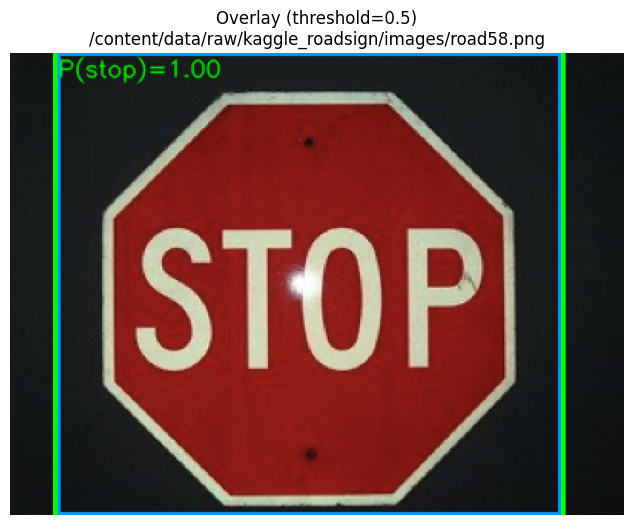

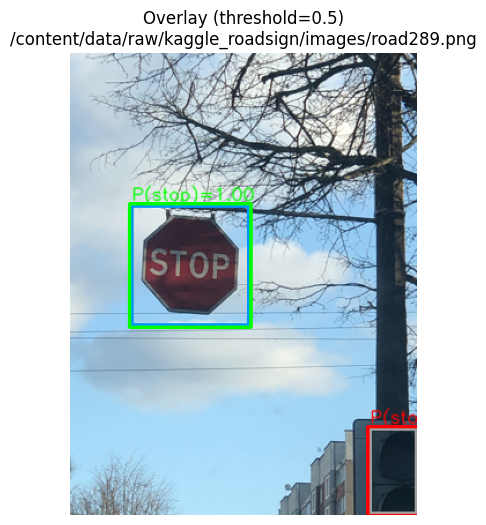

In [40]:
def draw_overlay(results, thresh=0.5):
    img = results["img"].copy()
    for item in results["crops"]:
        x1,y1,x2,y2 = item["bbox"]
        prob = item["prob"]
        gt = item["label"]  # 1 = stop
        # GT color for the inner box
        inner_color = (0, 150, 255) if gt==1 else (160,160,160)  # blue-ish for stop, gray for others
        cv2.rectangle(img, (x1,y1), (x2,y2), inner_color, 2)

        # Predicted frame (outer)
        pred_color = (0,255,0) if prob >= thresh else (255,0,0)  # green pass / red fail
        cv2.rectangle(img, (x1-2,y1-2), (x2+2,y2+2), pred_color, 2)

        text = f"P(stop)={prob:.2f}"
        cv2.putText(img, text, (x1, max(15,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, pred_color, 1, cv2.LINE_AA)
    return img

# Visualize overlay for the same sampled images
for p in sample_paths:
    rec = records_by_path[p]
    res = predict_crops_for_image(model, rec, max_pos=6, max_neg=6)
    overlay = draw_overlay(res, thresh=0.5)
    plt.figure(figsize=(8,6))
    plt.imshow(overlay)
    plt.title(f"Overlay (threshold=0.5)\n{p}")
    plt.axis('off')
    plt.show()
